## Fourth version of the EWC Notebook, here for the tonic perturbation dataset but using the same models and preprocessing as the force perturbation

In [1]:
import pandas as pd
import numpy as np
import xarray as xr

import os
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from src.helpers import *
from src.visualize import *
from src.trainer import *
from Models.models import *

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.metrics import *
from copy import deepcopy
import torch.utils.data as data
from torch.utils.data import Dataset

import pickle
import math

/home/nerea/anaconda3/envs/sinthlab/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys
sys.path.append("c:\\Users\\nerea\\OneDrive\\Documentos\\EPFL_MASTER\\PDM\\Project\\PyalData")
# to change for the actual path where PyalData has been cloned

In [3]:
from pyaldata import *

In [4]:
date = '0504'
name = 'Sansa'
fold = 1
target_variable = 'target_vel'

In [5]:
#@title Helper functions for plotting (run this cell!)
sns.set_context("notebook")

# initialize a color palette for plotting
palette = sns.xkcd_palette(["windows blue",
                            "red",
                            "medium green",
                            "dusty purple",
                            "orange",
                            "amber",
                            "clay",
                            "pink",
                            "greyish"])

In [6]:
to_t_eval =  lambda array: torch.tensor(array, device=device, dtype=dtype)  

## Load pre-processed data

In [7]:
data_path =  './Data/Processed_Data/Tidy_'+name+'_'+date+'.pkl'

with open(data_path, 'rb') as file:
    tidy_df = pickle.load(file)

In [8]:
baseline_df = tidy_df.loc[tidy_df.type == 'BASELINE'].reset_index()

In [9]:
tonic_df = tidy_df.loc[tidy_df.type == 'TONIC'].reset_index()

In [10]:
stim_df = tidy_df.loc[tidy_df.type == 'BC-REACH'].reset_index()

## Get train-val-test split

In [11]:
xx_train_base, yy_train_base, xx_val_base, yy_val_base,\
      xx_test_base, yy_test_base, info_train_base, info_val_base,\
          info_test_base, list_mins_base, \
            list_maxs_base= get_dataset(baseline_df, fold, target_variable= target_variable, no_outliers = False, force_data = False)

Train trials 18
Test trials  6
Val trials 5
We are testing the optimization method on fold  0


In [12]:
xx_train_tonic, yy_train_tonic, xx_val_tonic, yy_val_tonic,\
      xx_test_tonic, yy_test_tonic, info_train_tonic,\
          info_val_tonic, info_test_tonic,  list_mins_tonic,\
              list_maxs_tonic = get_dataset(tonic_df, fold, target_variable= target_variable, no_outliers = False)

Train trials 22
Test trials  7
Val trials 6
We are testing the optimization method on fold  0


In [13]:
xx_train_stim, yy_train_stim, xx_val_stim, yy_val_stim,\
      xx_test_stim, yy_test_stim, info_train_stim,\
          info_val_stim, info_test_stim,  list_mins_stim,\
              list_maxs_stim = get_dataset(stim_df, fold, target_variable= target_variable, no_outliers = False)

Train trials 44
Test trials  14
Val trials 11
We are testing the optimization method on fold  0


In [14]:
xx_train_all, yy_train_all, xx_val_all, yy_val_all,\
      xx_test_all, yy_test_all, info_train_all, info_val_all,\
          info_test_all,  list_mins_all, \
            list_maxs_all = get_dataset(tidy_df,fold, target_variable= target_variable, no_outliers = False)

Train trials 85
Test trials  27
Val trials 21


We are testing the optimization method on fold  0


In [15]:
# Specify that we want our tensors on the GPU and in float32
device = torch.device('cuda:0') #suposed to be cuda
#device = torch.device('cpu') 
dtype = torch.float32
path_to_models = './Models/Models_Force'

# Set the seed for reproducibility
seed_value = 42
torch.manual_seed(seed_value)
torch.cuda.manual_seed(seed_value)  # If using CUDA

num_dim_output = yy_train_base.shape[2]
num_features = xx_train_base.shape[2]

In [16]:
def weight_reset(m):
    reset_parameters = getattr(m, "reset_parameters", None)
    if callable(reset_parameters):
        m.reset_parameters()

## Baseline Model

#### Adding noise to the training data

In [17]:
# Add Gaussian noise to input features
#xx_train_base = torch.tensor(xx_train_base, dtype=torch.float32) + torch.tensor(np.random.normal(loc=0, scale=0.075, size=xx_train_base.shape), dtype=torch.float32)

In [18]:
# Define hyperparameters

#Hyperparameters objective and regularization
alpha_reg = 1e-5
l1_ratio_reg = 0.5

lr = 1e-5
loss_function = huber_loss
delta = 8  # hyperparameter for huber loss

# Hyperparameters LSTM class
hidden_units = 150
num_layers = 2
dropout = 0.2

#Other training hyperparameters

lr_gamma= 1.37 #for scheduler
lr_step_size = 10 #for scheduler

seq_length_LSTM= 19
batch_size_train= 15
batch_size_val = 15

torch.manual_seed(42)

In [19]:
model =  Causal_Simple_RNN(num_features=num_features, 
                hidden_units= hidden_units, 
                num_layers = num_layers, 
                out_dims = num_dim_output,
                dropout = dropout).to(device)

In [20]:
# Fit the LSTM model
model_base = model
model_base.apply(weight_reset)

Causal_Simple_RNN(
  (linear): Linear(in_features=150, out_features=3, bias=True)
  (rnn): RNN(128, 150, num_layers=2, batch_first=True)
  (selu): SELU()
  (dropout): Dropout(p=0.2, inplace=False)
)

In [21]:
train_losses, val_losses = \
    train_model(model_base, 
                xx_train_base,yy_train_base,
                xx_val_base, 
                yy_val_base,
                lr= lr,
                lr_step_size=lr_step_size,
                lr_gamma= lr_gamma,
                sequence_length_LSTM=seq_length_LSTM,
                batch_size_train = batch_size_train,
                batch_size_val = batch_size_val,
                num_epochs=1000, 
                delta = 8,                 
                regularizer= Regularizer_RNN, 
                l1_ratio = l1_ratio_reg,
                alpha = alpha_reg,     
                early_stop = 5)

Epoch 000 Train 3.7995 Val 2.4337
Epoch 001 Train 3.6024 Val 2.2573
Epoch 002 Train 3.4242 Val 2.1059
Epoch 003 Train 3.2683 Val 1.9893
Epoch 004 Train 3.1569 Val 1.9199
Epoch 005 Train 3.0817 Val 1.8762
Epoch 006 Train 3.0246 Val 1.8437
Epoch 007 Train 2.9753 Val 1.8156
Epoch 008 Train 2.9280 Val 1.7911
Epoch 009 Train 2.8911 Val 1.7701
Epoch 010 Train 2.8449 Val 1.7479
Epoch 011 Train 2.7978 Val 1.7168
Epoch 012 Train 2.7511 Val 1.7013
Epoch 013 Train 2.7107 Val 1.6763
Epoch 014 Train 2.6721 Val 1.6594
Epoch 015 Train 2.6396 Val 1.6372
Epoch 016 Train 2.6049 Val 1.6208
Epoch 017 Train 2.5731 Val 1.6029
Epoch 018 Train 2.5459 Val 1.5905
Epoch 019 Train 2.5153 Val 1.5930
Epoch 020 Train 2.4826 Val 1.5688
Epoch 021 Train 2.4477 Val 1.5744
Epoch 022 Train 2.4123 Val 1.5531
Epoch 023 Train 2.3812 Val 1.5752
Epoch 024 Train 2.3494 Val 1.5759
Epoch 025 Train 2.3183 Val 1.5890
Epoch 026 Train 2.2886 Val 1.5873
Decrease LR
Epoch 027 Train 2.2648 Val 1.6109
Epoch 028 Train 2.2422 Val 1.6166
Ep

In [22]:
y_hat, y_true, train_score, v_score, test_score = eval_model(xx_train_base, yy_train_base, xx_val_base, yy_val_base, xx_test_base, yy_test_base, model_base, metric = 'ev')

Train EV: 0.34 
Val EV: 0.40 
Test EV: 0.41 


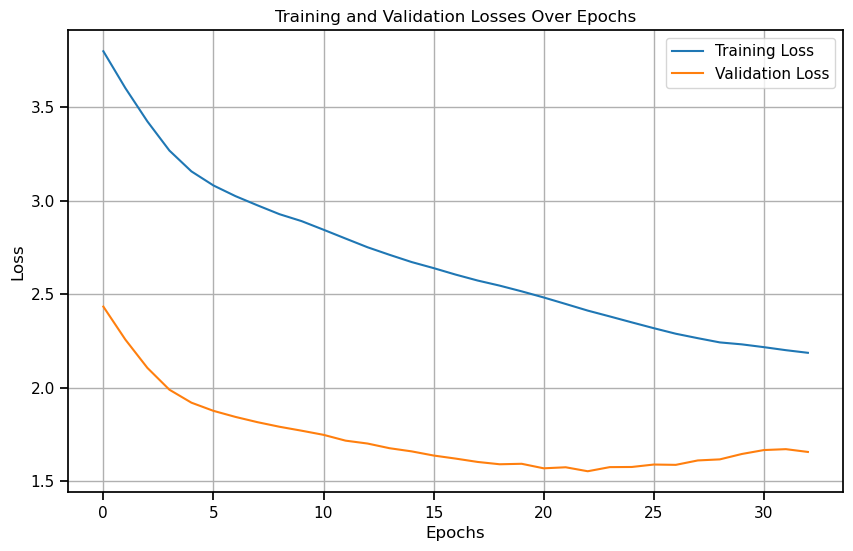

In [23]:
plot_losses(train_losses, val_losses)

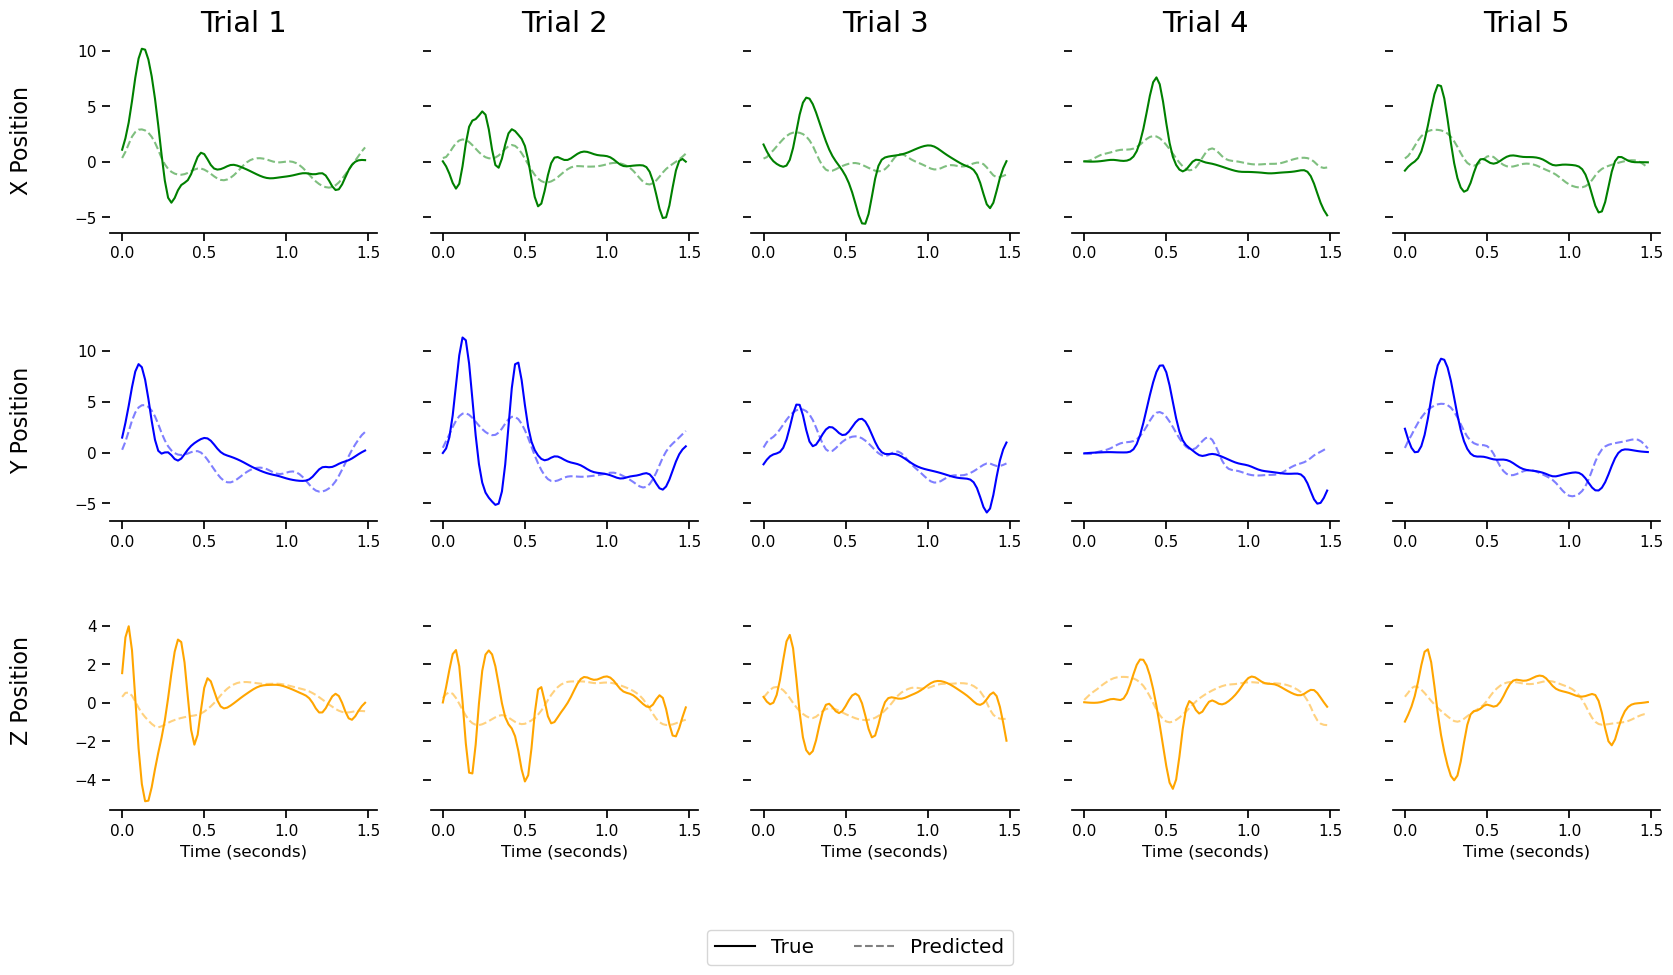

In [24]:
visualize_LSTM_test(y_hat, y_true, seq_length = 75)

In [25]:
# Fit the LSTM model
model_all = Causal_Simple_RNN(num_features=num_features, 
                hidden_units= hidden_units, 
                num_layers = num_layers, 
                out_dims = num_dim_output,
                dropout = dropout).to(device)
def weight_reset(m):
    reset_parameters = getattr(m, "reset_parameters", None)
    if callable(reset_parameters):
        m.reset_parameters()

model_all.apply(weight_reset)

Causal_Simple_RNN(
  (linear): Linear(in_features=150, out_features=3, bias=True)
  (rnn): RNN(128, 150, num_layers=2, batch_first=True)
  (selu): SELU()
  (dropout): Dropout(p=0.2, inplace=False)
)

In [26]:
train_losses, val_losses = \
    train_model(model_all, xx_train_all,yy_train_all,
                xx_val_all, 
                yy_val_all,
                lr= 1e-5,
                lr_step_size=lr_step_size,
                lr_gamma= lr_gamma,
                sequence_length_LSTM=seq_length_LSTM,
                batch_size_train = batch_size_train,
                batch_size_val = batch_size_val,
                num_epochs=1000, 
                delta = 8,                 
                regularizer=Regularizer_RNN,
                l1_ratio = l1_ratio_reg,# Assuming you have already trained your model and collected the losses
                alpha = alpha_reg,     
                early_stop = 5,
                
                )

Epoch 000 Train 2.6722 Val 2.0300
Epoch 001 Train 2.0647 Val 1.7905
Epoch 002 Train 1.8861 Val 1.6857
Epoch 003 Train 1.7895 Val 1.6255
Epoch 004 Train 1.7292 Val 1.5803
Epoch 005 Train 1.6827 Val 1.5430
Epoch 006 Train 1.6426 Val 1.5071
Epoch 007 Train 1.6082 Val 1.4772
Epoch 008 Train 1.5757 Val 1.4475
Epoch 009 Train 1.5468 Val 1.4238
Epoch 010 Train 1.5165 Val 1.4007
Epoch 011 Train 1.4850 Val 1.3753
Epoch 012 Train 1.4557 Val 1.3710
Epoch 013 Train 1.4324 Val 1.3332
Epoch 014 Train 1.4099 Val 1.3258
Epoch 015 Train 1.3897 Val 1.3137
Epoch 016 Train 1.3741 Val 1.3104
Epoch 017 Train 1.3580 Val 1.2871
Epoch 018 Train 1.3420 Val 1.2788
Epoch 019 Train 1.3293 Val 1.2869
Epoch 020 Train 1.3181 Val 1.2766
Epoch 021 Train 1.3032 Val 1.2741
Epoch 022 Train 1.2890 Val 1.2505
Epoch 023 Train 1.2757 Val 1.2437
Epoch 024 Train 1.2628 Val 1.2339
Epoch 025 Train 1.2493 Val 1.2414
Epoch 026 Train 1.2409 Val 1.2489
Epoch 027 Train 1.2298 Val 1.2149
Epoch 028 Train 1.2227 Val 1.2419
Epoch 029 Trai

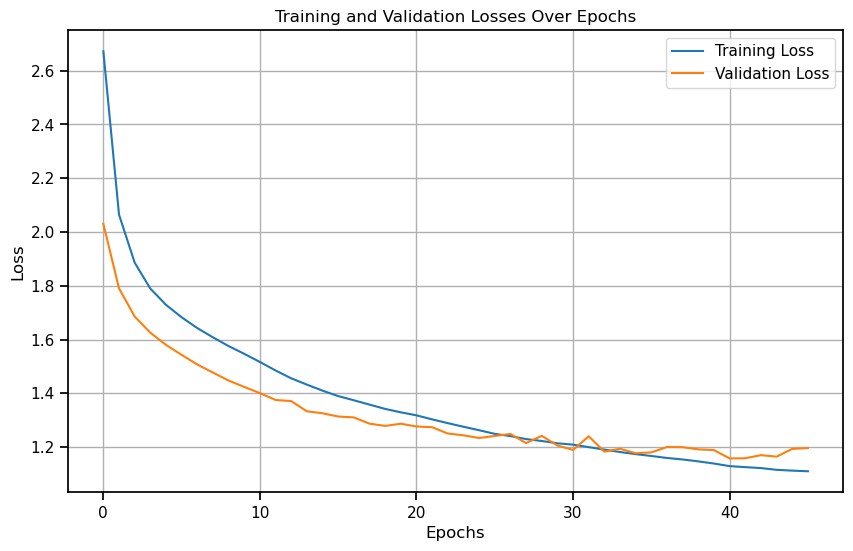

In [27]:
# train_losses and val_losses are numpy arrays containing losses for each epoch
plot_losses(train_losses, val_losses)

In [28]:
y_hat, y_true, train_score, v_score, test_score = eval_model(xx_train_all, yy_train_all, xx_val_all, yy_val_all, xx_test_all, yy_test_all, model_all, metric = 'ev')


Train EV: 0.58 
Val EV: 0.59 
Test EV: 0.57 


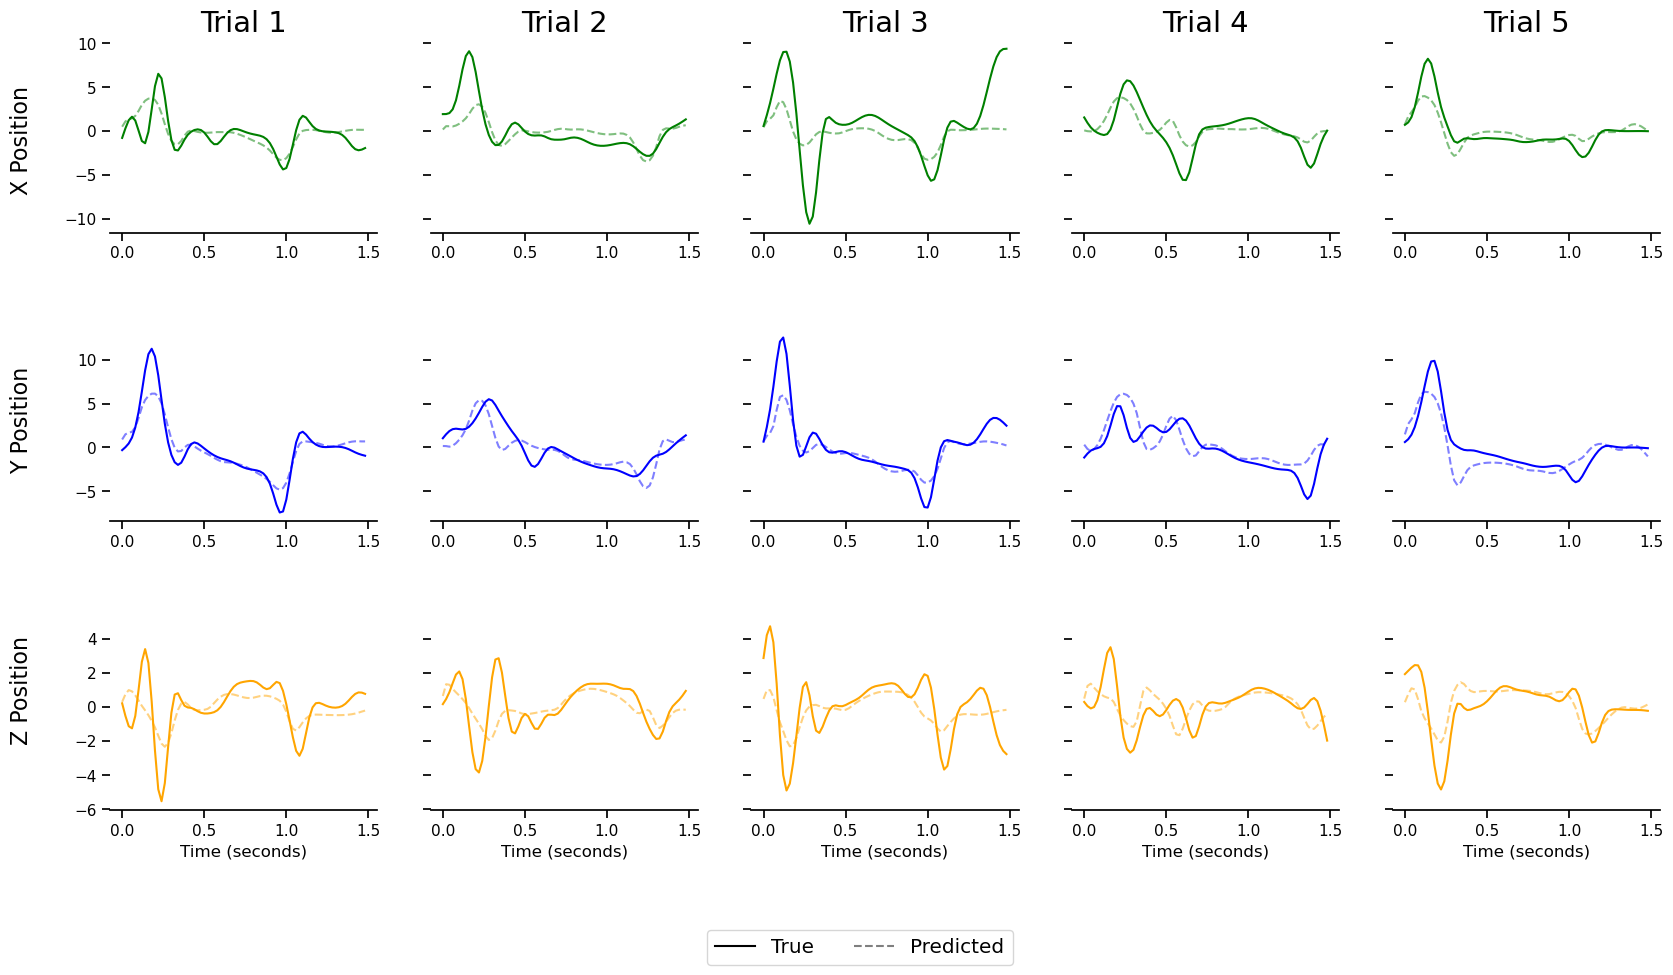

In [29]:
visualize_LSTM_test(y_hat, y_true, seq_length = 75)


In [30]:
# Fit the LSTM model
model_stim =  Causal_Simple_RNN(num_features=num_features, 
                hidden_units= hidden_units, 
                num_layers = num_layers, 
                out_dims = num_dim_output,
                dropout = dropout).to(device)

model_stim.apply(weight_reset)

Causal_Simple_RNN(
  (linear): Linear(in_features=150, out_features=3, bias=True)
  (rnn): RNN(128, 150, num_layers=2, batch_first=True)
  (selu): SELU()
  (dropout): Dropout(p=0.2, inplace=False)
)

In [31]:
train_losses, val_losses = \
    train_model(model_stim, xx_train_stim,yy_train_stim,
                xx_val_stim, 
                yy_val_stim,
                lr= lr,
                lr_step_size=lr_step_size,
                lr_gamma= lr_gamma,
                sequence_length_LSTM=seq_length_LSTM,
                batch_size_train = batch_size_train,
                batch_size_val = batch_size_val,
                num_epochs=1000, 
                delta = 8,                 
                regularizer= Regularizer_RNN,
                l1_ratio = l1_ratio_reg,
                alpha = alpha_reg,     
                early_stop = 5,
                
                )

Epoch 000 Train 2.6450 Val 2.1377
Epoch 001 Train 2.1451 Val 1.7351
Epoch 002 Train 1.8745 Val 1.5989
Epoch 003 Train 1.7516 Val 1.5226
Epoch 004 Train 1.6460 Val 1.4669
Epoch 005 Train 1.5584 Val 1.4347
Epoch 006 Train 1.4923 Val 1.3998
Epoch 007 Train 1.4389 Val 1.3684
Epoch 008 Train 1.3919 Val 1.3421
Epoch 009 Train 1.3524 Val 1.3144
Epoch 010 Train 1.3120 Val 1.2870
Epoch 011 Train 1.2664 Val 1.2566
Epoch 012 Train 1.2267 Val 1.2373
Epoch 013 Train 1.1911 Val 1.2297
Epoch 014 Train 1.1611 Val 1.2032
Epoch 015 Train 1.1329 Val 1.1826
Epoch 016 Train 1.1061 Val 1.1875
Epoch 017 Train 1.0830 Val 1.1700
Epoch 018 Train 1.0610 Val 1.1607
Epoch 019 Train 1.0429 Val 1.1454
Epoch 020 Train 1.0264 Val 1.1310
Epoch 021 Train 1.0069 Val 1.1241
Epoch 022 Train 0.9895 Val 1.1151
Epoch 023 Train 0.9771 Val 1.1170
Epoch 024 Train 0.9643 Val 1.1192
Epoch 025 Train 0.9502 Val 1.1082
Epoch 026 Train 0.9395 Val 1.1200
Epoch 027 Train 0.9265 Val 1.1265
Epoch 028 Train 0.9190 Val 1.1093
Epoch 029 Trai

In [32]:
y_hat, y_true, train_score, v_score, test_score = eval_model(xx_train_stim,yy_train_stim,
                xx_val_stim, 
                yy_val_stim, xx_test_stim, yy_test_stim, model_stim, metric = 'ev')


Train EV: 0.71 
Val EV: 0.56 
Test EV: 0.58 


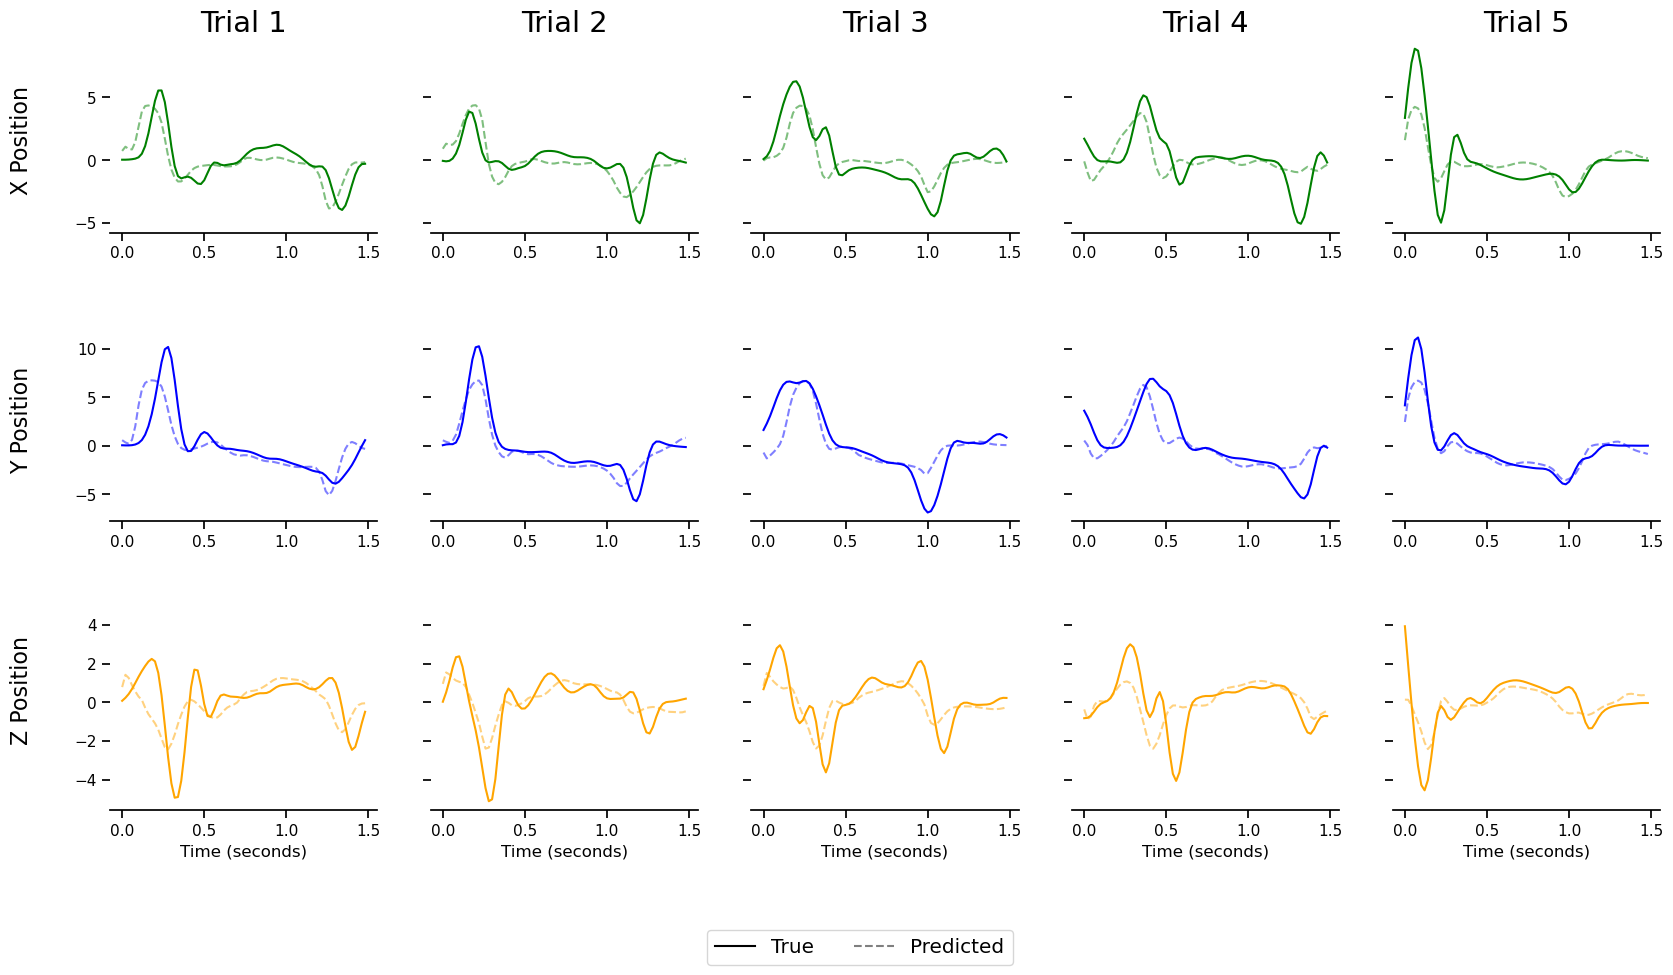

In [33]:
visualize_LSTM_test(y_hat, y_true, seq_length = 75)

In [34]:
model_tonic = Causal_Simple_RNN(num_features=num_features, 
                hidden_units= hidden_units, 
                num_layers = num_layers, 
                out_dims = num_dim_output,
                dropout = dropout).to(device)

model_tonic.apply(weight_reset)

Causal_Simple_RNN(
  (linear): Linear(in_features=150, out_features=3, bias=True)
  (rnn): RNN(128, 150, num_layers=2, batch_first=True)
  (selu): SELU()
  (dropout): Dropout(p=0.2, inplace=False)
)

In [35]:
train_losses, val_losses = \
    train_model(model_tonic, xx_train_tonic, yy_train_tonic, 
                xx_val_tonic, yy_val_tonic,
                lr= lr,
                lr_step_size=lr_step_size,
                lr_gamma= lr_gamma,
                sequence_length_LSTM=seq_length_LSTM,
                batch_size_train = batch_size_train,
                batch_size_val = batch_size_val,
                num_epochs=1000, 
                delta = 8,                 
                regularizer= Regularizer_RNN,
                l1_ratio = l1_ratio_reg,
                alpha = alpha_reg,     
                early_stop = 5,
                
                )

Epoch 000 Train 2.8600 Val 2.4735
Epoch 001 Train 2.5674 Val 2.2356
Epoch 002 Train 2.2824 Val 2.0125
Epoch 003 Train 2.0191 Val 1.8535
Epoch 004 Train 1.8399 Val 1.7787
Epoch 005 Train 1.7381 Val 1.7435
Epoch 006 Train 1.6730 Val 1.7215
Epoch 007 Train 1.6224 Val 1.7011
Epoch 008 Train 1.5788 Val 1.6792
Epoch 009 Train 1.5413 Val 1.6600
Epoch 010 Train 1.5017 Val 1.6297
Epoch 011 Train 1.4581 Val 1.6009
Epoch 012 Train 1.4178 Val 1.5798
Epoch 013 Train 1.3836 Val 1.5567
Epoch 014 Train 1.3518 Val 1.5320
Epoch 015 Train 1.3185 Val 1.5046
Epoch 016 Train 1.2937 Val 1.4963
Epoch 017 Train 1.2653 Val 1.4712
Epoch 018 Train 1.2399 Val 1.4541
Epoch 019 Train 1.2148 Val 1.4317
Epoch 020 Train 1.1864 Val 1.4151
Epoch 021 Train 1.1558 Val 1.4057
Epoch 022 Train 1.1273 Val 1.3804
Epoch 023 Train 1.0998 Val 1.3748
Epoch 024 Train 1.0726 Val 1.3513
Epoch 025 Train 1.0491 Val 1.3560
Epoch 026 Train 1.0292 Val 1.3471
Epoch 027 Train 1.0060 Val 1.3468
Epoch 028 Train 0.9897 Val 1.3446
Epoch 029 Trai

Epoch 035 Train 0.8912 Val 1.3961
Epoch 036 Train 0.8833 Val 1.4098
Epoch 037 Train 0.8811 Val 1.3997
Epoch 038 Train 0.8762 Val 1.4288
Decrease LR
29


In [36]:
y_hat, y_true, train_score, v_score, test_score = eval_model(xx_train_tonic,yy_train_tonic,
                xx_val_tonic, 
                yy_val_tonic, xx_test_tonic, yy_test_tonic, model_stim, metric = 'ev')


Train EV: 0.58 
Val EV: 0.56 
Test EV: 0.62 


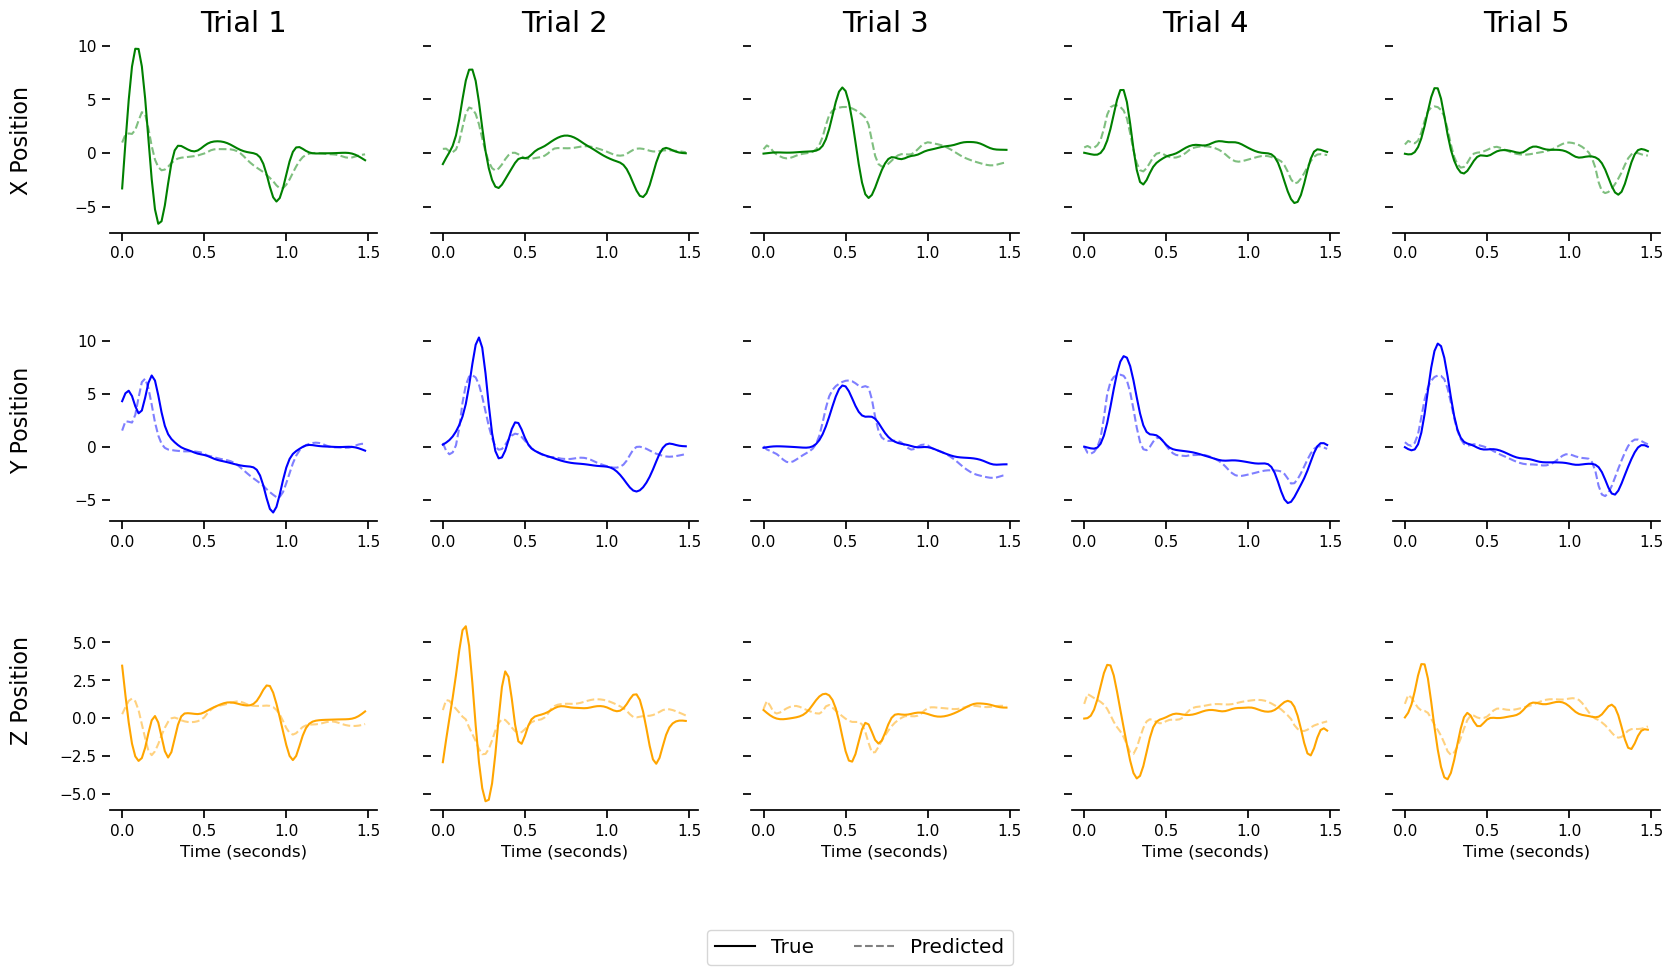

In [37]:
visualize_LSTM_test(y_hat, y_true, seq_length = 75)